# Modelos_NaiveBayes_LDA

In [1]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import cross_validate , StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, make_scorer , confusion_matrix, classification_report, ConfusionMatrixDisplay , precision_recall_curve , RocCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, roc_curve, f1_score, average_precision_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler




https://sinyi-chou.github.io/python-sklearn-precision-recall/ <br>
https://sinyi-chou.github.io/classification-pr-curve/ 

In [2]:
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root # Importar el módulo root

## Modelos info users

In [3]:
file_path = root.DIR_DATA_STAGE + 'train_infousers.csv'

In [4]:
df_infousers = pd.read_csv(file_path)
df_infousers.head()

,PLAZO,CAPITAL,DÍAS MORA,INGRESOS MENSUALES,GASTOS MENSUALES,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,latitud,longitud,meses_transcurridos,...,ESTADO CIVIL_viudo/a,NIVEL EDUCATIVO_postgrado,NIVEL EDUCATIVO_primaria,NIVEL EDUCATIVO_profesional,NIVEL EDUCATIVO_secundaria,NIVEL EDUCATIVO_tecnico,NIVEL EDUCATIVO_tecnologo,TIPO DE VEHICULO_moto,TIPO DE VEHICULO_ninguno,Cuotas en mora
0,13.0,0.17,1532.0,1.100,0.20,1.0,0.0,4.60971,-74.08175,20.499343,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
1,30.0,0.30,1783.0,1.274,0.50,1.0,0.0,6.25184,-75.56359,48.127464,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,30.0,0.35,1304.0,2.500,1.20,1.0,0.0,5.53528,-73.36778,31.192510,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
3,30.0,0.25,544.0,1.250,0.95,1.0,0.0,6.25184,-75.56359,138.961892,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
4,30.0,0.20,1986.0,1.000,0.40,1.0,0.0,6.25184,-75.56359,31.192510,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0


## Balanceo

### info usuarios

In [5]:
X = df_infousers.drop(columns=['Cuotas en mora'])
X = StandardScaler().fit_transform(X)
y = df_infousers['Cuotas en mora']

In [6]:
# Inicializar los modelos
logistic_regression = LogisticRegression(max_iter=1000)
naive_bayes = GaussianNB()
lda = LinearDiscriminantAnalysis()

In [7]:
metricas = ['accuracy', 'precision', 'recall', 'f1','roc_auc','average_precision']

In [8]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
logistic_scores = cross_validate(logistic_regression, X, y, cv=cv, scoring=metricas)
naive_bayes_scores = cross_validate(naive_bayes, X, y, cv=cv, scoring=metricas)
lda_scores = cross_validate(lda, X, y, cv=cv, scoring=metricas)

In [10]:
def print_results(model_name, scores):
    print(f"\n{model_name}")
    for metrica in metricas:
        mean_score = np.mean(scores[f'test_{metrica}'])
        std_score = np.std(scores[f'test_{metrica}'])
        print(f"{metrica.capitalize()}: {mean_score:.2f} +/- {std_score * 2:.2f}")

print_results("Regresión Logística", logistic_scores)
print_results("Naive Bayes", naive_bayes_scores)
print_results("LDA", lda_scores)


Regresión Logística
Accuracy: 0.78 +/- 0.01
Precision: 0.80 +/- 0.02
Recall: 0.87 +/- 0.03
F1: 0.83 +/- 0.01
Roc_auc: 0.83 +/- 0.02
Average_precision: 0.87 +/- 0.03

Naive Bayes
Accuracy: 0.61 +/- 0.24
Precision: 0.71 +/- 0.08
Recall: 0.68 +/- 0.69
F1: 0.62 +/- 0.59
Roc_auc: 0.73 +/- 0.05
Average_precision: 0.80 +/- 0.06

LDA
Accuracy: 0.77 +/- 0.02
Precision: 0.80 +/- 0.02
Recall: 0.86 +/- 0.04
F1: 0.83 +/- 0.02
Roc_auc: 0.83 +/- 0.02
Average_precision: 0.88 +/- 0.03


In [11]:
def CV_scores(X, y, model_cv,k = 5):

    # Initialize the KFold
    kf = KFold(n_splits=k, random_state=42, shuffle=True)

    recall_vec = []
    precision_vec = []
    accuracy_vec = []
    f1_vec = []
    AP_vec = []
    AUC_vec = []
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X[train_index], X[test_index]
        y_train_cv, y_test_cv = y.values[train_index], y.values[test_index]
        
        ros = RandomOverSampler(random_state=0)
        X_train_cv, y_train_cv = ros.fit_resample(X_train_cv, y_train_cv)

        # Fit the model
        model_cv.fit(X_train_cv, y_train_cv)

        # Make predictions
        y_pred = model_cv.predict(X_test_cv)
        
        # Calcular la precisión del modelo
        accuracy = accuracy_score(y_test_cv, y_pred)
        precision = precision_score(y_test_cv, y_pred)
        recall = recall_score(y_test_cv, y_pred)
        f1 = f1_score(y_test_cv, y_pred)
        AP = average_precision_score(y_test_cv, y_pred)
        AUC = roc_auc_score(y_test_cv, y_pred)
        
        recall_vec.append(recall)
        precision_vec.append(precision)
        accuracy_vec.append(accuracy)
        f1_vec.append(f1)
        AP_vec.append(AP)
        AUC_vec.append(AUC)
        
        
     
    recall =  np.mean(recall_vec)
    precision = np.mean(precision_vec)
    accuracy = np.mean(accuracy_vec)
    f1 = np.mean(f1_vec)
    AP = np.mean(AP_vec)
    AUC = np.mean(AUC_vec)
        
    metricas = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'PR-AUC': AP,
        'ROC-AUC': AUC,
    }
    return metricas
    

In [12]:
LR_score = CV_scores(X, y, LogisticRegression())
NB_score = CV_scores(X, y, GaussianNB())
LDA_score = CV_scores(X, y, LinearDiscriminantAnalysis())
print(LR_score)
print(NB_score)
print(LDA_score)

{'Accuracy': 0.7620040298684367, 'Precision': 0.8338293421011421, 'Recall': 0.7771614897043986, 'F1-score': 0.8043760962546193, 'PR-AUC': 0.7885026474459208, 'ROC-AUC': 0.7565480150887551}
{'Accuracy': 0.6172478369088539, 'Precision': 0.6892679308007625, 'Recall': 0.6735795666830089, 'F1-score': 0.6242903754764689, 'PR-AUC': 0.6826803322229147, 'ROC-AUC': 0.5952347120580259}
{'Accuracy': 0.7644674647386512, 'Precision': 0.8308231564316939, 'Recall': 0.7865030500597476, 'F1-score': 0.8078924399458224, 'PR-AUC': 0.787985551750254, 'ROC-AUC': 0.756457440542086}


## Modelos para CredInfo

In [13]:
file_path = root.DIR_DATA_STAGE + 'train_creditinfo.csv'

In [14]:
df_credit_info = pd.read_csv(file_path)
df_credit_info.head()

,PLAZO,CAPITAL,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,mes,mora
0,30,500000,4,1,10,1
1,30,350000,5,1,1,1
2,30,300000,1,0,4,1
3,30,210000,3,1,10,1
4,29,400000,2,1,10,1


In [15]:
X = df_credit_info.drop(columns=['mora'])
X = StandardScaler().fit_transform(X)
y = df_credit_info['mora']

## Scores usando k startify K-fold

In [16]:
logistic_scores = cross_validate(logistic_regression, X, y, cv=cv, scoring=metricas)
naive_bayes_scores = cross_validate(naive_bayes, X, y, cv=cv, scoring=metricas)
lda_scores = cross_validate(lda, X, y, cv=cv, scoring=metricas)

In [17]:
print_results("Regresión Logística", logistic_scores)
print_results("Naive Bayes", naive_bayes_scores)
print_results("LDA", lda_scores)


Regresión Logística
Accuracy: 0.81 +/- 0.01
Precision: 0.86 +/- 0.01
Recall: 0.59 +/- 0.01
F1: 0.70 +/- 0.01
Roc_auc: 0.89 +/- 0.01
Average_precision: 0.82 +/- 0.01

Naive Bayes
Accuracy: 0.79 +/- 0.01
Precision: 0.80 +/- 0.01
Recall: 0.58 +/- 0.01
F1: 0.67 +/- 0.01
Roc_auc: 0.86 +/- 0.01
Average_precision: 0.79 +/- 0.01

LDA
Accuracy: 0.79 +/- 0.00
Precision: 0.91 +/- 0.01
Recall: 0.49 +/- 0.01
F1: 0.64 +/- 0.01
Roc_auc: 0.88 +/- 0.01
Average_precision: 0.81 +/- 0.01


### Scoring con Kfold normal , balancendo solo train_cv

In [18]:
LR_score = CV_scores(X, y, LogisticRegression())
NB_score = CV_scores(X, y, GaussianNB())
LDA_score = CV_scores(X, y, LinearDiscriminantAnalysis())
print(LR_score)
print(NB_score)
print(LDA_score)

{'Accuracy': 0.7940780010712215, 'Precision': 0.6884179171822831, 'Recall': 0.821829436372496, 'F1-score': 0.7492006862979639, 'PR-AUC': 0.632448870464834, 'ROC-AUC': 0.7996665381708312}
{'Accuracy': 0.7672195214043953, 'Precision': 0.6819729145764871, 'Recall': 0.7088263733855518, 'F1-score': 0.6950336811000847, 'PR-AUC': 0.5923592645615245, 'ROC-AUC': 0.7555274792125177}
{'Accuracy': 0.7942160277998361, 'Precision': 0.8902298699766057, 'Recall': 0.5134888363274105, 'F1-score': 0.6512950002819251, 'PR-AUC': 0.6392301530568366, 'ROC-AUC': 0.737810652923257}


## Modelación

### Naive Bayes

In [19]:
##Función pára curva lift

def plot_comulative_gain(y_true, y_proba, ax):
    # Create a dataframe with true labels and predicted probabilities
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    df = df.sort_values('y_proba', ascending=False).reset_index(drop=True)
    
    # Calculate the cumulative gain for the lift curve
    df['cumulative_data_fraction'] = (np.arange(len(df)) + 1) / len(df)
    df['cumulative_positive_fraction'] = np.cumsum(df['y_true']) / df['y_true'].sum()
    
    # Plot the lift curve
    ax.plot(df['cumulative_data_fraction'], df['cumulative_positive_fraction'], label='Cumulative Gain Curve')
    ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Baseline')
    ax.set_title('Cumulative Gain Curve')
    ax.set_xlabel('Cumulative Data Fraction')
    ax.set_ylabel('Cumulative Positive Fraction')
    ax.legend()

In [20]:
def plot_lift_curve(y_true, y_proba, ax):
    df = pd.DataFrame({'y_true': y_true, 'y_proba': y_proba})
    df = df.sort_values('y_proba', ascending=False).reset_index(drop=True)
    
    # Calculate the cumulative gain for the lift curve
    df['cumulative_data_fraction'] = (np.arange(len(df)) + 1) / len(df)
    df['cumulative_positive_fraction'] = np.cumsum(df['y_true']) / df['y_true'].sum()
    df['lift'] = df['cumulative_positive_fraction'] / df['cumulative_data_fraction']
    
    ax.plot(df['cumulative_data_fraction'], df['lift'], label='Lift Curve')
    ax.set_title('Lift Curve')
    ax.set_xlabel('Cumulative Data Fraction')
    ax.set_ylabel('Lift')
    ax.legend()
    

In [21]:
def plot_precision_recall_curve(y, y_proba, ax):
    ax.set_title('Train Data')
    prsn, rcll, _ = precision_recall_curve(y, y_proba)
    AP = average_precision_score(y, y_proba)
    ax.plot(rcll, prsn, label= f'Precison-Recall AP = {round(AP,2)})')
    ax.set_title('Precision Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()

In [22]:
def modelo(df,target_col,model):
    
    X = df.drop(columns=[target_col])
    X = StandardScaler().fit_transform(X)
    y = df[target_col]
    
    ros = RandomOverSampler(random_state=0)
    X, y = ros.fit_resample(X, y)
    
    model.fit(X, y)
    
    return model

In [23]:
def graficas(df, target_col, model):
    
    scaler = StandardScaler()
    X = df.drop(columns=[target_col])
    columns = X.columns
    X = scaler.fit_transform(X)
    y = df[target_col]
   
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1] 
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    AP = average_precision_score(y, y_proba)
    AUC = roc_auc_score(y, y_proba)

   
    print("Accuracy: {:.3f}".format(accuracy))
    print("Precision: {:.3f}".format(precision))
    print("Recall: {:.3f}".format(recall))
    print("F1 Score: {:.3f}".format(f1))
    print("Average Precision: {:.3f}".format(AP))
    print("Area Under the ROC Curve: {:.3f}".format(AUC))
    print('------------------------------------------------------------------------------')
    #print(classification_report(y, y_pred))
    
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    disp = ConfusionMatrixDisplay.from_estimator(model, X, y, normalize='true', xticks_rotation='vertical', ax=axs)
    axs.set_title("Confusion Matrix")  # Add a title to the plot
    plt.show()
    

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    disp = RocCurveDisplay.from_estimator(model, X, y, ax=axs[0][0])
    axs[0][0].set_title('ROC Curve')
    axs[0][0].plot([0, 1], [0, 1], linestyle='--', color='grey', label='Baseline')
    plot_precision_recall_curve(y, y_proba, ax=axs[0][1])
    plot_lift_curve(y, y_proba, ax=axs[1][0])
    plot_comulative_gain(y, y_proba, ax=axs[1][1])
    
    fig.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.show()
    
    df = pd.DataFrame(scaler.inverse_transform(X), columns=columns)
    
    df['Estado'] = y
    df['Estado_Estimado'] = y_pred
    df['Probabilidad'] = np.round(y_proba * 100,2)
    
    return df

## Para infouser

In [24]:
file_path2 = root.DIR_DATA_STAGE + 'test_infousers.csv'
test_infousers = pd.read_csv(file_path2)

In [25]:
Modelo1 = modelo(df_infousers,'Cuotas en mora',logistic_regression)

Accuracy: 0.797
Precision: 0.865
Recall: 0.803
F1 Score: 0.833
Average Precision: 0.900
Area Under the ROC Curve: 0.851
------------------------------------------------------------------------------


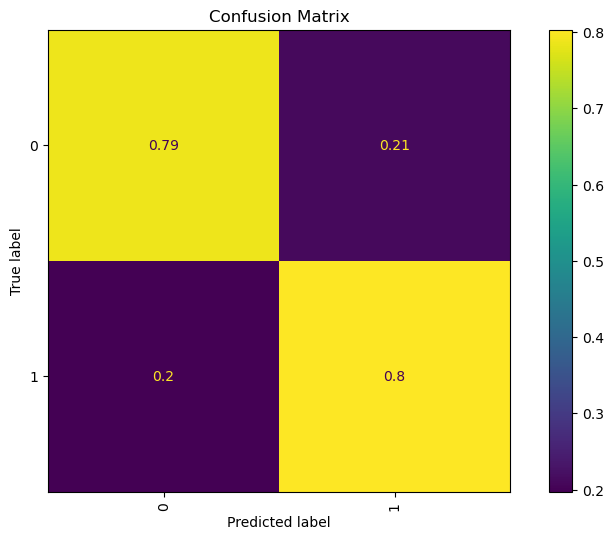

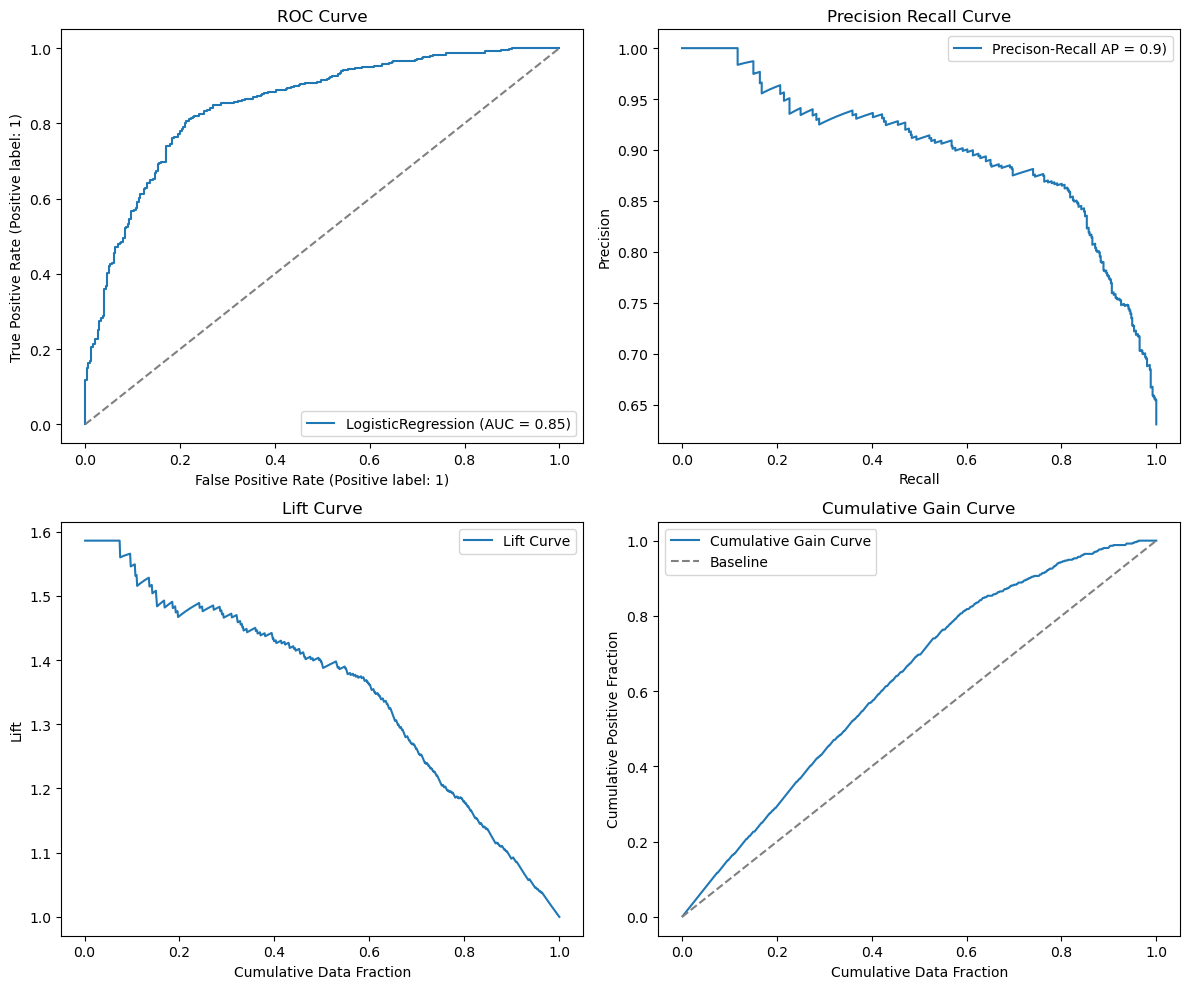

In [26]:
df_final1 = graficas (test_infousers,'Cuotas en mora', model = Modelo1)

## Para credit_info

In [27]:
file_path2 = root.DIR_DATA_STAGE + 'test_creditinfo.csv'
test_credit_info = pd.read_csv(file_path2)

In [28]:
Modelo2 = modelo(df_credit_info,'mora',logistic_regression)

Accuracy: 0.790
Precision: 0.684
Recall: 0.816
F1 Score: 0.744
Average Precision: 0.811
Area Under the ROC Curve: 0.881
------------------------------------------------------------------------------


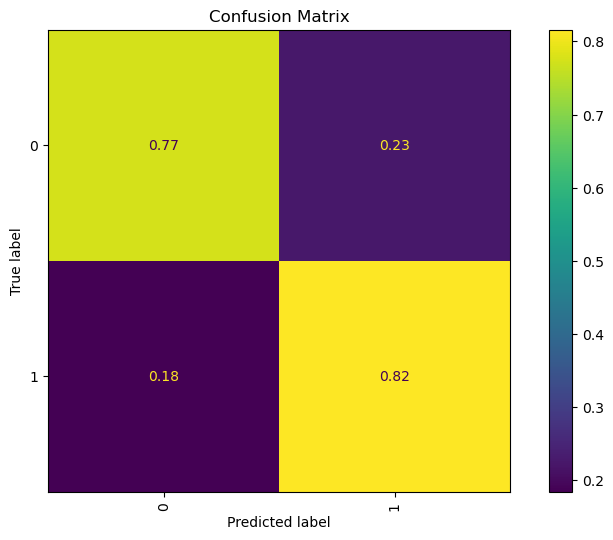

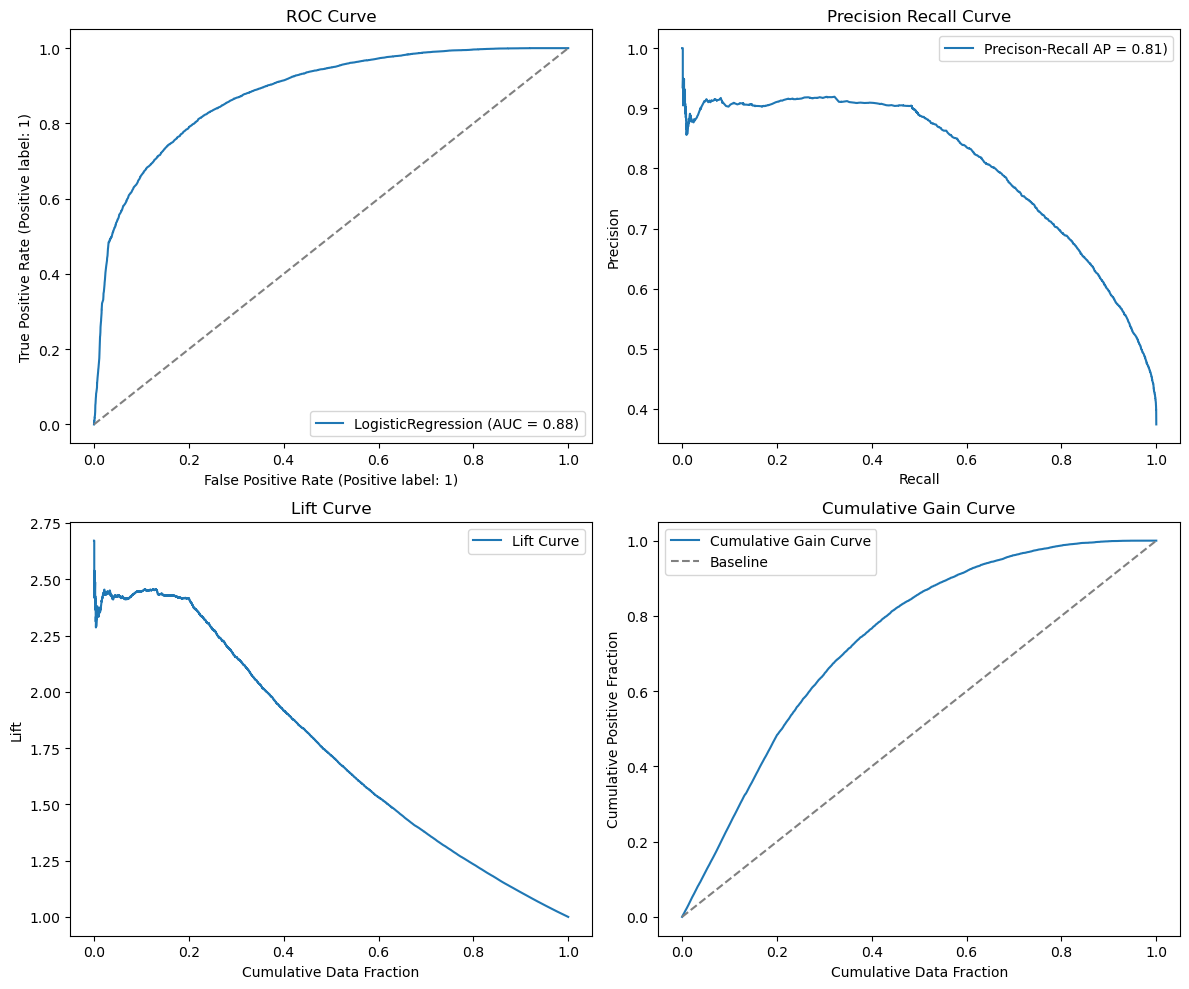

In [29]:
df_final2 = graficas (test_credit_info,'mora', model = Modelo2)

In [30]:
df_final2.head()

,PLAZO,CAPITAL,NUM.CREDITOS SOLICITADOS,USUARIO RECURRENTE,mes,Estado,Estado_Estimado,Probabilidad
0,30.0,470000.0,28.0,1.000000e+00,5.0,0,0,0.40
1,30.0,230000.0,1.0,1.110223e-16,2.0,1,1,93.88
2,30.0,300000.0,5.0,1.000000e+00,1.0,0,0,41.13
3,30.0,200000.0,6.0,1.000000e+00,10.0,0,0,38.00
4,30.0,300000.0,10.0,1.000000e+00,11.0,0,0,20.93
